# Initial CNN Training Script

This script trains a simple CNN model for Hand Gesture Reconition in order to serve as a baseline for more complex and pretrained models, using the using the [Hagrid Dataset for Classification](https://huggingface.co/datasets/cj-mills/hagrid-classification-512p-no-gesture-150k-zip) dataset.

The model is divided into two parts: the feature extractor and the classifier. The feature extractor consists of a series of convolutional layers followed by max pooling layers. The classifier consists of a series of fully connected layers. The model is trained using the cross-entropy loss function and the Adam optimizer.

Below we import all the necessary libraries for the training script and get the device to be used for training.

In [2]:
# Importing Libraries
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim.lr_scheduler as lr_scheduler
from typing import List
import os
import cv2
from sklearn.preprocessing import LabelEncoder
import pickle
from torchvision import models

# Use GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

c:\Users\berna\anaconda3\envs\cv-gesture\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


We then define a Dataset class that will be used to load the data and preprocess it before feeding it to the model. All images are resized to 300x300 and converted from BGR to RGB and normalized.

We also use a LabelEncoder to encode the labels and a function to convert the encoded labels back to the original labels.

In [3]:
# Custom Dataset Class
# This class loads images from a directory and applies a transformation to them
# The images are resized to 300x300 and normalized to [0, 1]
class CustomDataset(Dataset):
    def __init__(self, image_dir: str, label_encoder, transform=None):
        self.image_dir = image_dir
        self.label_encoder = label_encoder
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for label in os.listdir(image_dir):
            class_dir = os.path.join(image_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.jpeg'):
                    self.image_paths.append(os.path.join(class_dir, file_name))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (300, 300))  # Resize to 300x300
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        label = torch.tensor(self.label_encoder.transform([label])[0], dtype=torch.long)
        return image, label


# Load image paths and labels
def load_labels(dir: str) -> List[str]:
    labels = []
    for folder in os.listdir(dir):
        folder_path = os.path.join(dir, folder)
        if os.path.isdir(folder_path):
            labels.append(folder)
    return labels

# Load labels
input_dir = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\train_val\\original"
labels = load_labels(input_dir)

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)
pickle.dump(label_encoder, open('labelencoder.pkl', 'wb'))

# Create the dataset
dataset = CustomDataset(input_dir, label_encoder)

We then split the data into training and validation sets and create the DataLoader objects for both sets.

In [4]:
# Split data into train and validation sets at an 80/20 ratio
train_ratio = 0.8
val_ratio = 1-train_ratio
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

We then define the model to be used for training. The model consists of a series of convolutional layers followed by max pooling layers and a series of fully connected layers. The model is trained using the cross-entropy loss function and the Adam optimizer.

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, input_width, input_height):
        """
        Initializes the SimpleCNN class.

        Args:
            num_classes (int): The number of classes for classification.
            input_width (int): The width of the input image.
            input_height (int): The height of the input image.
        """
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Calculate the size of the feature map after the convolutional layers
        # Assume input dimensions are (input_height, input_width)
        def conv2d_size_out(size, kernel_size=3, stride=1, padding=1):
            return (size + 2 * padding - kernel_size) // stride + 1
        
        def maxpool2d_size_out(size, kernel_size=2, stride=2, padding=0):
            return (size + 2 * padding - kernel_size) // stride + 1
        
        convw = conv2d_size_out(input_width)
        convw = maxpool2d_size_out(convw)
        convw = conv2d_size_out(convw)
        convw = maxpool2d_size_out(convw)
        convw = conv2d_size_out(convw)
        convw = maxpool2d_size_out(convw)
        convw = conv2d_size_out(convw)
        convw = maxpool2d_size_out(convw)
        convw = conv2d_size_out(convw)
        convw = maxpool2d_size_out(convw)
        
        convh = conv2d_size_out(input_height)
        convh = maxpool2d_size_out(convh)
        convh = conv2d_size_out(convh)
        convh = maxpool2d_size_out(convh)
        convh = conv2d_size_out(convh)
        convh = maxpool2d_size_out(convh)
        convh = conv2d_size_out(convh)
        convh = maxpool2d_size_out(convh)
        convh = conv2d_size_out(convh)
        convh = maxpool2d_size_out(convh)
        
        self.fc_input_dim = 512 * convw * convh
        
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Generate the SimpleCNN model
def generate_simple_cnn(num_classes: int, input_width: int, input_height: int):
    model = SimpleCNN(num_classes, input_width, input_height)
    return model

We then define the batch size, and Data Loaders for the training and validation sets.

We also create a class to Save the Best Model during training, by comparing the validation loss and saving the model with the lowest validation loss.

In [6]:
# Define the batch size and create the data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


class SaveModelWithBestValLoss:
    """
    Class that saves the best model during a training process. If the current epoch's validation loss 
    is smaller than the previous smallest validation loss saved, it saves the model state.
    The best valid loss is initialized to infinity.
    """
    def __init__(
        self, smallest_valid_loss=float('inf')
    ):
        self.smallest_valid_loss = smallest_valid_loss
        
    def save(
        self, current_valid_loss, epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.smallest_valid_loss:
            self.smallest_valid_loss = current_valid_loss
            print(f"Saving best model for epoch {epoch+1}, with new best validation loss: {self.smallest_valid_loss}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

In [7]:
# Check if data loading works
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 24588
Number of validation samples: 6147


The training loop is defined, using the Adam optimizer and the CrossEntropyLoss. The laerning rate has a scheduler to reduce from a 1.0 factor to 0.3 factor in 50 epochs, starting from 1e-4.

The model is trained for a maximum of 50 epochs, implementing an Early Stopping mechanism where if the Validation Loss hasn't improved after 4 epochs it stops the training process, and the best model is saved.

In [8]:
# Create the model
model = generate_simple_cnn(len(label_encoder.classes_), 300, 300)
model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

# Define the class to save the best model based on the validation loss
save_best_model_instance = SaveModelWithBestValLoss()

# Variables to store the training and validation losses
train_losses = []
val_losses = []
lrs = []

# Training Loop
for epoch in range(50):
    # Set model to training mode
    model.train()
    
    # Initialize tqdm progress bar
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    train_loss = 0.0

    # Iterate over the training data
    for batch in train_bar:
        # Get the inputs and labels
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(inputs)

        # Calculate the loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Update the learning rate
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        # Update training loss
        train_loss += loss.item()
        train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    val_loss = 0.0
    model.eval()

    # Initialize tqdm progress bar for validation
    val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    
    # Iterate over the validation data
    with torch.no_grad():
        for batch in val_bar:
            # Get the inputs and labels
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(inputs)

            # Calculate the loss
            loss = criterion(logits, labels)
            
            # Update validation loss
            val_loss += loss.item()
            val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Check if the validation loss has not improved for the last 3 epochs
    if len(val_losses) >= 4:
        diff_val_loss_1 = val_losses[-2] - val_losses[-1]
        diff_val_loss_2 = val_losses[-3] - val_losses[-1]
        diff_val_loss_3 = val_losses[-4] - val_losses[-1]
        # If the validation loss has not improved for the last 3 epochs, stop training
        if diff_val_loss_3 < 0 and diff_val_loss_2 < 0 and diff_val_loss_1 < 0:
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss} DID NOT IMPROVE')
            break
    
    # Print the training and validation loss
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save model if validation model loss decreases
    save_best_model_instance.save(
        avg_val_loss, epoch, model, optimizer, criterion
    )

Training Epoch 0:   0%|          | 0/1537 [00:00<?, ?it/s]c:\Users\berna\anaconda3\envs\cv-gesture\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Training Epoch 0: 100%|█████████▉| 1536/1537 [03:42<00:00,  5.67it/s, training_loss=1.318]c:\Users\berna\anaconda3\envs\cv-gesture\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Validation Epoch 0: 100%|█████████▉| 384

Epoch 1, Training Loss: 2.704740381349428, Validation Loss: 2.6337378913706
Saving best model for epoch 1, with new best validation loss: 2.6337378913706



Validation Epoch 1: 100%|██████████| 385/385 [00:45<00:00,  8.54it/s, validation_loss=1.330]


Epoch 2, Training Loss: 2.584144620439335, Validation Loss: 2.5325986707365358
Saving best model for epoch 2, with new best validation loss: 2.5325986707365358



Validation Epoch 2: 100%|██████████| 385/385 [00:46<00:00,  8.35it/s, validation_loss=1.322]


Epoch 3, Training Loss: 2.4973023830487033, Validation Loss: 2.431241478858056
Saving best model for epoch 3, with new best validation loss: 2.431241478858056



Validation Epoch 3: 100%|██████████| 385/385 [00:45<00:00,  8.39it/s, validation_loss=1.351]


Epoch 4, Training Loss: 2.389552186197791, Validation Loss: 2.3276607847833013
Saving best model for epoch 4, with new best validation loss: 2.3276607847833013



Validation Epoch 4: 100%|██████████| 385/385 [00:46<00:00,  8.25it/s, validation_loss=0.961]


Epoch 5, Training Loss: 2.2799209408273, Validation Loss: 2.2127845296612034
Saving best model for epoch 5, with new best validation loss: 2.2127845296612034



Validation Epoch 5: 100%|██████████| 385/385 [00:44<00:00,  8.72it/s, validation_loss=0.920]


Epoch 6, Training Loss: 2.1614642685391954, Validation Loss: 2.1125359940838506
Saving best model for epoch 6, with new best validation loss: 2.1125359940838506



Validation Epoch 6: 100%|██████████| 385/385 [00:45<00:00,  8.40it/s, validation_loss=1.240]


Epoch 7, Training Loss: 2.0612874407231536, Validation Loss: 2.000024081824662
Saving best model for epoch 7, with new best validation loss: 2.000024081824662



Validation Epoch 7: 100%|██████████| 385/385 [00:45<00:00,  8.45it/s, validation_loss=0.605]


Epoch 8, Training Loss: 1.9607985767359537, Validation Loss: 1.8966722349067786
Saving best model for epoch 8, with new best validation loss: 1.8966722349067786



Validation Epoch 8: 100%|██████████| 385/385 [00:45<00:00,  8.37it/s, validation_loss=1.136]


Epoch 9, Training Loss: 1.8507247315883326, Validation Loss: 1.8007766418642812
Saving best model for epoch 9, with new best validation loss: 1.8007766418642812



Validation Epoch 9: 100%|██████████| 385/385 [00:46<00:00,  8.25it/s, validation_loss=0.834]


Epoch 10, Training Loss: 1.7433343552193552, Validation Loss: 1.7405175020168353
Saving best model for epoch 10, with new best validation loss: 1.7405175020168353



Validation Epoch 10: 100%|██████████| 385/385 [00:46<00:00,  8.32it/s, validation_loss=0.644]


Epoch 11, Training Loss: 1.6492407547628716, Validation Loss: 1.6309166593985125
Saving best model for epoch 11, with new best validation loss: 1.6309166593985125



Validation Epoch 11: 100%|██████████| 385/385 [00:45<00:00,  8.40it/s, validation_loss=0.933]


Epoch 12, Training Loss: 1.5358851723804363, Validation Loss: 1.6248847606894259
Saving best model for epoch 12, with new best validation loss: 1.6248847606894259



Validation Epoch 12: 100%|██████████| 385/385 [00:33<00:00, 11.40it/s, validation_loss=1.359]


Epoch 13, Training Loss: 1.4348666174076716, Validation Loss: 1.5000765150243587
Saving best model for epoch 13, with new best validation loss: 1.5000765150243587



Validation Epoch 13: 100%|██████████| 385/385 [00:37<00:00, 10.37it/s, validation_loss=0.857]


Epoch 14, Training Loss: 1.3232990326087197, Validation Loss: 1.4380521243268793
Saving best model for epoch 14, with new best validation loss: 1.4380521243268793



Validation Epoch 14: 100%|██████████| 385/385 [00:31<00:00, 12.37it/s, validation_loss=0.310]


Epoch 15, Training Loss: 1.219680611516798, Validation Loss: 1.4079895203763788
Saving best model for epoch 15, with new best validation loss: 1.4079895203763788



Validation Epoch 15: 100%|██████████| 385/385 [00:30<00:00, 12.50it/s, validation_loss=1.017]


Epoch 16, Training Loss: 1.116799077548683, Validation Loss: 1.3570246218086837
Saving best model for epoch 16, with new best validation loss: 1.3570246218086837



Validation Epoch 16: 100%|██████████| 385/385 [00:30<00:00, 12.51it/s, validation_loss=1.073]


Epoch 17, Training Loss: 1.0232606439541592, Validation Loss: 1.3245912234504502
Saving best model for epoch 17, with new best validation loss: 1.3245912234504502



Validation Epoch 17: 100%|██████████| 385/385 [00:30<00:00, 12.43it/s, validation_loss=0.540]


Epoch 18, Training Loss: 0.937110018055394, Validation Loss: 1.3184863697398792
Saving best model for epoch 18, with new best validation loss: 1.3184863697398792



Validation Epoch 18: 100%|██████████| 385/385 [00:30<00:00, 12.47it/s, validation_loss=0.004]


Epoch 19, Training Loss: 0.8399204207595169, Validation Loss: 1.3218016928352125


Validation Epoch 19: 100%|██████████| 385/385 [00:30<00:00, 12.44it/s, validation_loss=0.897]


Epoch 20, Training Loss: 0.7521938239802923, Validation Loss: 1.3143721866143214
Saving best model for epoch 20, with new best validation loss: 1.3143721866143214



Validation Epoch 20: 100%|██████████| 385/385 [00:31<00:00, 12.42it/s, validation_loss=0.270]

Epoch 21, Validation Loss: 1.3508866658458463 DID NOT IMPROVE


We plot the training and validation loss and accuracy and save the model and the training history.

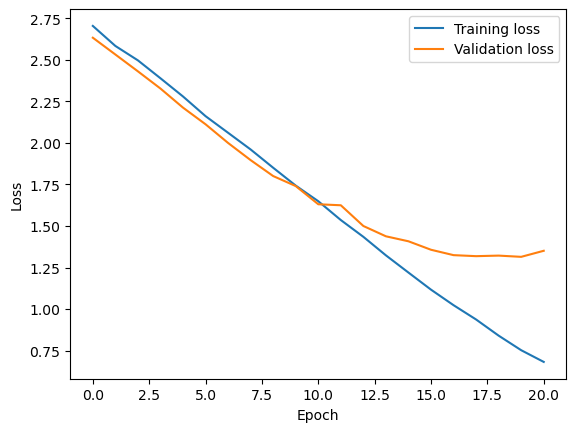

In [9]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

We load the best model and use to test the model on the test set, to evaluate the model's performance on unseen data.

Test: 100%|██████████| 961/961 [01:00<00:00, 15.97it/s]


Accuracy: 0.6137576467525706
Precision: 0.6122703498022093
Recall: 0.6137576467525706
F1: 0.6103739631214996
                 precision    recall  f1-score   support

           call       0.70      0.69      0.70       693
        dislike       0.72      0.75      0.74       702
           fist       0.57      0.69      0.63       688
           four       0.44      0.56      0.49       718
           like       0.61      0.60      0.60       682
           mute       0.75      0.81      0.78       713
     no_gesture       0.87      0.90      0.89      2782
             ok       0.49      0.39      0.43       692
            one       0.45      0.40      0.43       706
           palm       0.56      0.56      0.56       705
          peace       0.42      0.41      0.42       696
 peace_inverted       0.60      0.62      0.61       687
           rock       0.56      0.45      0.50       688
           stop       0.52      0.41      0.46       689
  stop_inverted       0.53      0.6

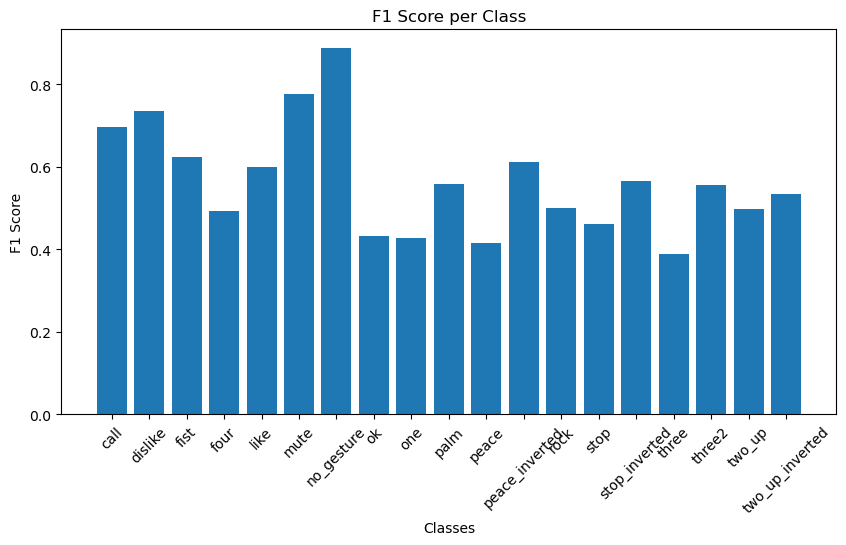

In [14]:
# Load the test data
test_dir = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\test"
test_dataset = CustomDataset(test_dir, label_encoder)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Build the model
saved_model = generate_simple_cnn(len(label_encoder.classes_), 300, 300)
saved_model.to(device)
# Load the best model and load the state dict
best_model = torch.load('best_model.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for Test
    test_bar = tqdm(test_loader, desc='Test')

    # Iterate over the test data
    for batch in test_bar:
        # Get the inputs and labels
        input_ids, labels = batch
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids)

        # Get the predicted labels
        #_, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = logits.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Convert the predictions to binary
threshold = 0.5
all_preds_binary = []
for pred in all_preds:
    all_preds_binary.append(np.argmax(pred))

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds_binary)
precision = precision_score(all_labels, all_preds_binary, average='weighted')
recall = recall_score(all_labels, all_preds_binary, average='weighted')
f1 = f1_score(all_labels, all_preds_binary, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Generate metrics per class
from sklearn.metrics import classification_report
target_names = label_encoder.classes_
print(classification_report(all_labels, all_preds_binary, target_names=target_names))


# Show a bar plot of the F1 score per class
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
f1_scores = f1_score(all_labels, all_preds_binary, average=None)
plt.figure(figsize=(10, 5))
plt.bar(target_names, f1_scores)
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class')
plt.xticks(rotation=45)
plt.show()



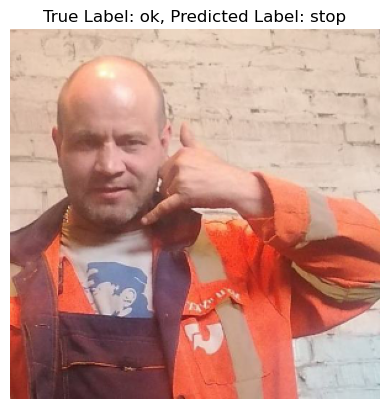

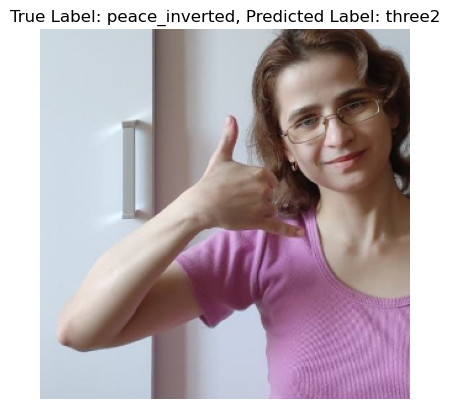

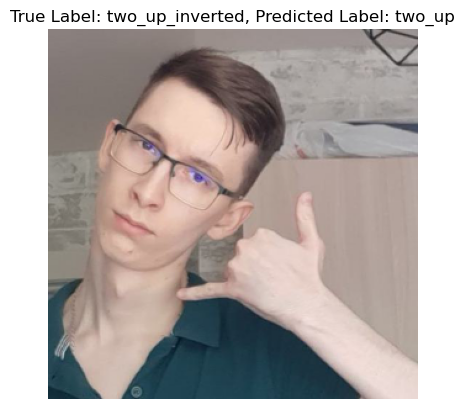

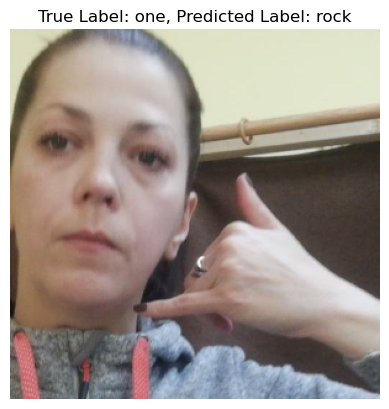

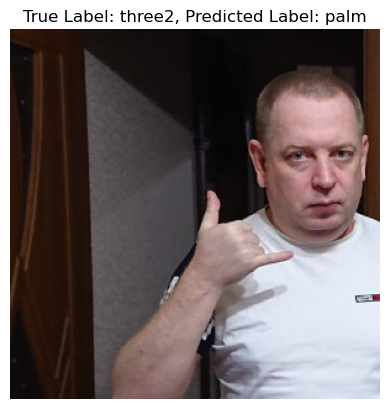

In [11]:
# Show some examples of misclassified images
import numpy as np
import matplotlib.pyplot as plt

# Convert the labels back to their original form
all_labels_original = label_encoder.inverse_transform(all_labels)
all_preds_original = label_encoder.inverse_transform(all_preds_binary)

# Find the indices of misclassified images
misclassified_indices = np.where(np.array(all_labels_original) != np.array(all_preds_original))[0]

# Display the first 5 misclassified images
num_images_to_display = 5
for i in range(num_images_to_display):
    index = misclassified_indices[i]
    image, label = test_dataset[index]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.title(f"True Label: {all_labels_original[index]}, Predicted Label: {all_preds_original[index]}")
    plt.axis('off')
    plt.show()

We define a function that allows for prediction of a single image using the model.

In [12]:
# Function that allows for one prediction to be made for a single image using the trained model
def predict_single_image(model, image_path: str, label_encoder):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (300, 300))  # Resize to 300x300
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
    image = image.unsqueeze(0)  # Add batch dimension
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(image.to(device))
        preds = torch.argmax(logits, dim=-1)
    
    # Decode the prediction
    label = label_encoder.inverse_transform([preds.item()])[0]
    return label

We predict the class of a single image using the model and display the image and the predicted class.

c:\Users\berna\anaconda3\envs\cv-gesture\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


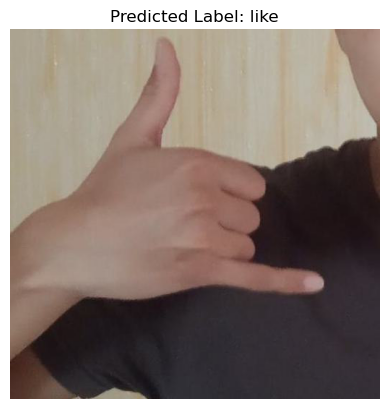

In [13]:
#Predict a single image
image_path = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\test\\call\\0a8c60fc-9ef4-4de5-b601-3dee17ee110d.jpeg"
predicted_label = predict_single_image(saved_model, image_path, label_encoder)
# Show the image along with the predicted label
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()
